In [1]:
import numpy as np
import pandas as pd
import yaml

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, roc_curve, roc_auc_score, auc, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

# Load the configuration file

In [2]:
with open("workspace/config.yml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

lame = config['lame']
path = f"{config['path_to_data']}/{lame}"

# Load the data

In [3]:
# Load the selected peaks in the region with the given frequency
peaks = pd.read_csv(f"{path}/results/mse_spectra_region.csv")

# Load the selected region pixels features
pixels = pd.read_csv(f"{path}/results/mse_pixels_region.csv")

# Plot the pixels densities extracted from the IHC images

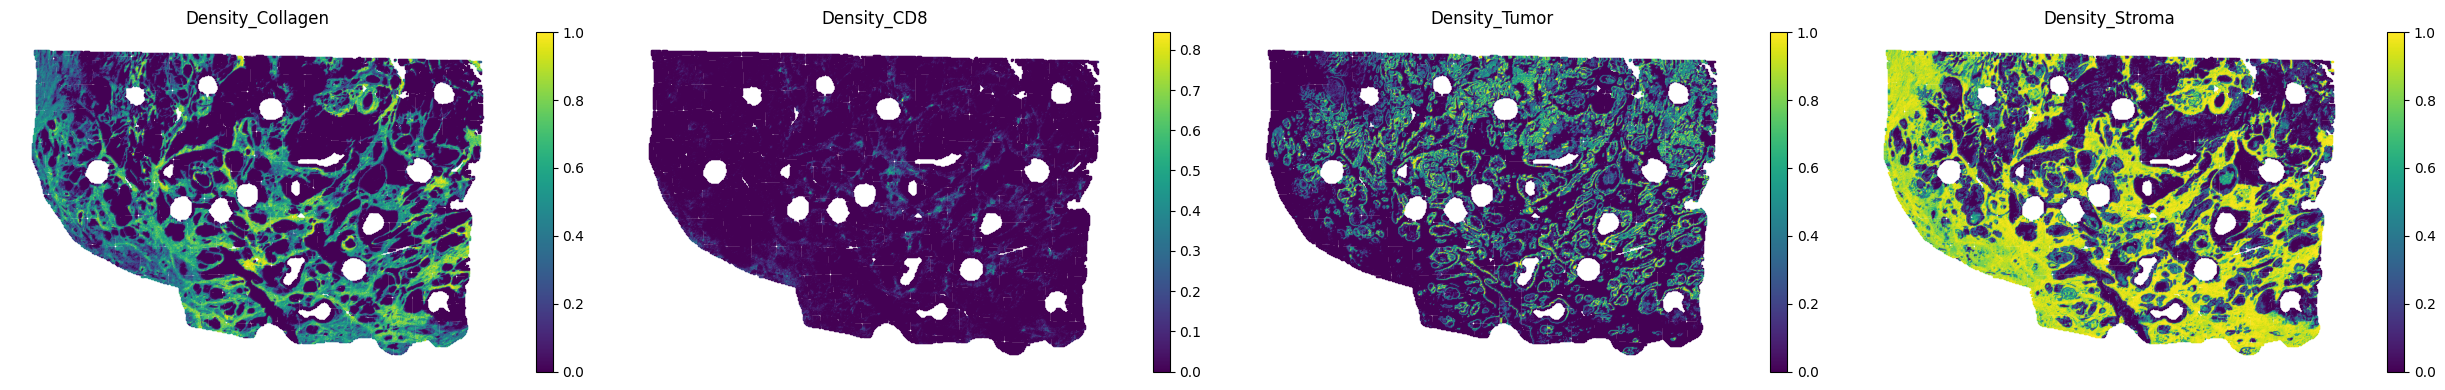

In [4]:
# Determine the densities of the selected pixels
densities = [col for col in pixels.columns if 'Density' in col][2:]

fig, axs = plt.subplots(1, 4, figsize=(25, 4), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, density in zip(axs.flatten(), densities):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels[density], cmap='viridis', s=0.5, marker='s')
    ax.set_title(density)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

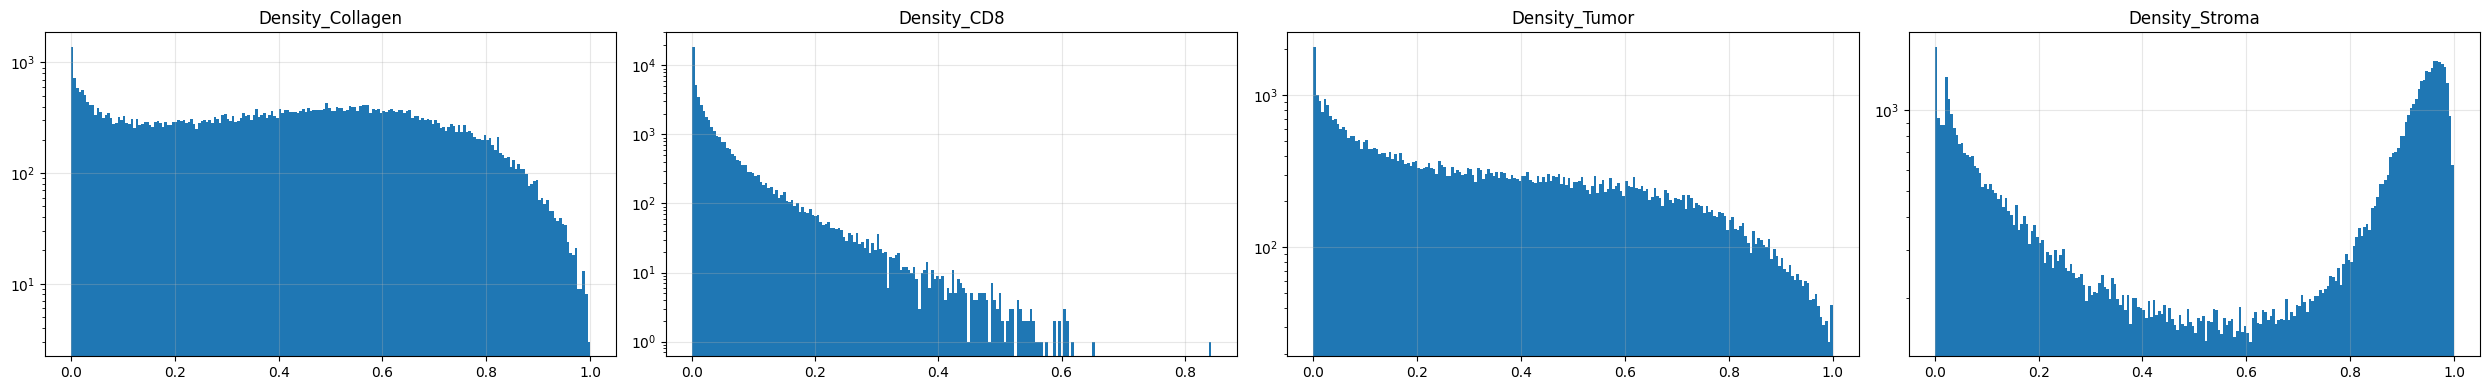

In [5]:
# Make a histogram of the pixel densities data
fig, axs = plt.subplots(1, 4, figsize=(25, 4), tight_layout=True)

for ax, density in zip(axs.flatten(), densities):
    ax.hist(pixels[density][pixels[density] != 0], bins=200)
    ax.set_title(density)
    ax.set_yscale('log')
    ax.grid(alpha=0.3)

plt.show()

# Define a threshold for the pixel densities, then plot the density thresholded masks

In [6]:
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

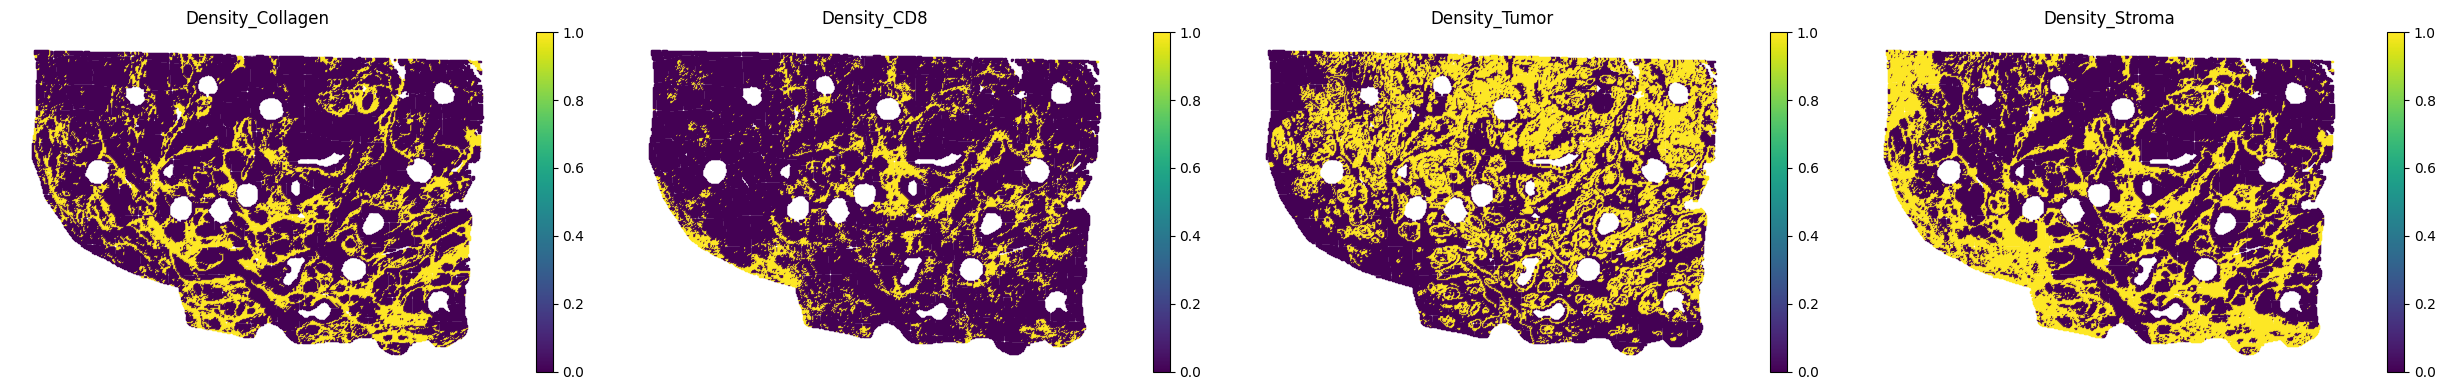

In [7]:
# plot the pixels densities with threshold
fig, axs = plt.subplots(1, 4, figsize=(25, 4), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, density in zip(axs.flatten(), densities):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels[density] > threshold[density], cmap='viridis', s=0.5, marker='s')
    ax.set_title(density)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

# Split the data into training and testing sets

In [8]:
# Sample data
X = peaks.values
y = pixels['Density_CD8'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform a linear regression

In [9]:
# Create a linear regression model
model_reg = LinearRegression()

# Train the model
model_reg.fit(X_train, y_train)

# Make predictions
y_pred = model_reg.predict(X_test)

# Compute R-squared
r2_train = model_reg.score(X_train, y_train)
r2_test = r2_score(y_test, y_pred)

# Compute the mean squared error
mse_train = mean_squared_error(y_train, model_reg.predict(X_train))
mse_test = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (train): {mse_train:.5f}")
print(f"Mean Squared Error (test): {mse_test:.5f}")
print(f"R-squared (train): {r2_train:.2f}")
print(f"R-squared (test): {r2_test:.2f}")

Mean Squared Error (train): 0.00159
Mean Squared Error (test): 0.00166
R-squared (train): 0.25
R-squared (test): 0.23


In [10]:
# Sample data
X = peaks.values
y = pixels['Density_CD8'].values

# Create a linear regression model
model_reg = LinearRegression()

# Train the model
model_reg.fit(X, y)

print(f"Pearson correlation: {np.corrcoef(y, model_reg.predict(X))[0, 1]:.2f}")
print(f"Spearman correlation: {np.corrcoef(y, model_reg.predict(X))[0, 1]:.2f}")

Pearson correlation: 0.50
Spearman correlation: 0.50


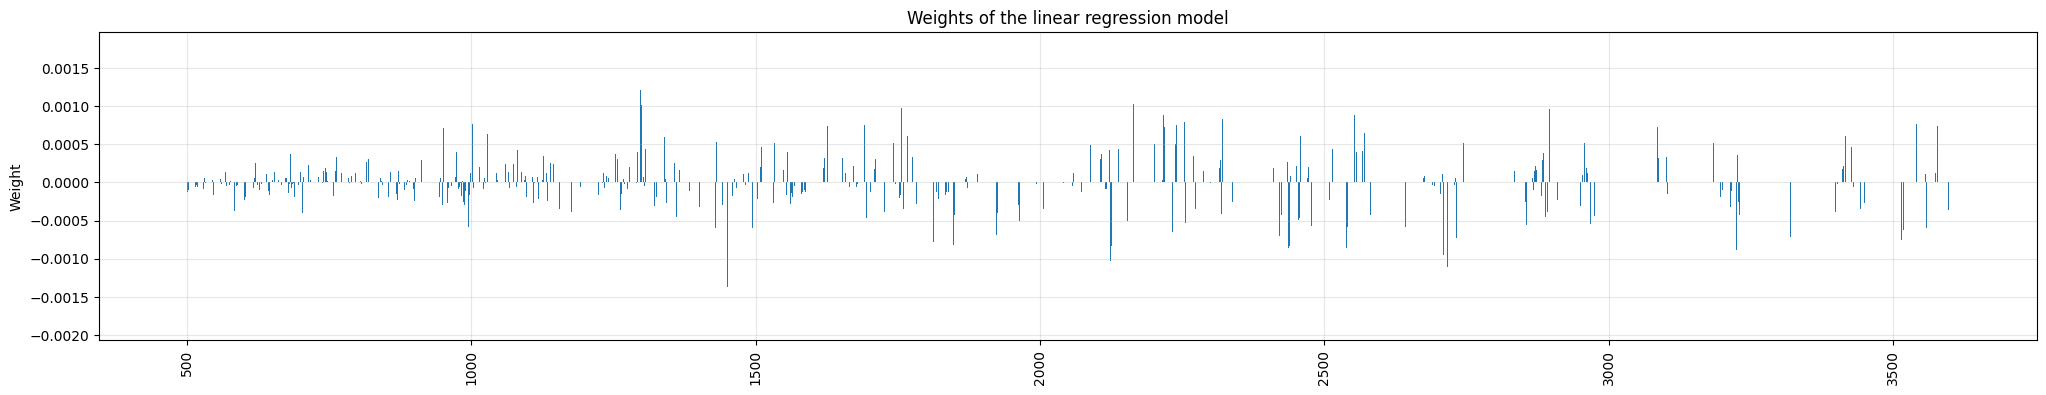

In [11]:
# Compute the weights of the model
weights = model_reg.coef_

# Plot the weights
plt.figure(figsize=(25, 4))
plt.bar(peaks.columns.astype(float), weights)
plt.xticks(rotation=90)
plt.ylabel('Weight')
plt.title('Weights of the linear regression model')
plt.grid(alpha=0.3)
plt.show()

In [12]:
peaks_all = pd.read_csv(f"{path}/results/mse_spectra.csv")
pixels_all = pd.read_csv(f"{path}/results/pixels_maldi_warped_density_df.csv")

Pearson correlation: 0.36


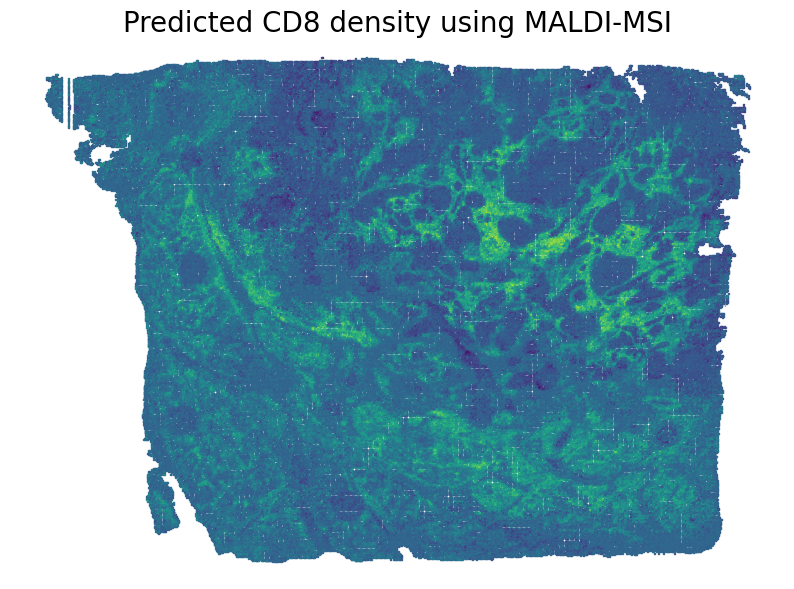

In [13]:
# Apply the weights to the peaks
predicted_cd8 = model_reg.predict(peaks_all.values)

# Compute the correlation between the predicted CD8+ T cell density and the actual CD8+ T cell density
print(f"Pearson correlation: {np.corrcoef(pixels_all["Density_CD8"], predicted_cd8)[0, 1]:.2f}")

# Plot the predicted CD8+ T cell density
plt.figure(figsize=(10, 7))
plt.scatter(x=pixels_all['x_warped'], y=pixels_all['y_warped'], c=predicted_cd8, cmap='viridis', s=0.5, marker='s')
plt.title('Predicted CD8 density using MALDI-MSI', fontsize=20)
plt.gca().invert_yaxis()
plt.gca().axis('equal')
plt.axis('off')
plt.show()

In [14]:
# Compute the Pearson correlation between each mass in the peaks and the CD8 density
corr_pearson = []
for mass in peaks.columns:
    corr = np.corrcoef(peaks[mass], pixels["Density_CD8"])[0, 1]
    corr_pearson.append(corr)

# Compute the Spearman correlation between each mass in the peaks and the CD8 density
corr_spearman = []
for mass in peaks.columns:
    corr = peaks[mass].corr(pixels["Density_CD8"], method='spearman')
    corr_spearman.append(corr)

# Compute the log2 fold change between the CD8 high and low groups
fold_change = []
for mass in peaks.columns:
    high = peaks[mass][pixels["Density_CD8"] > threshold["Density_CD8"]]
    low = peaks[mass][pixels["Density_CD8"] <= threshold["Density_CD8"]]
    fc = np.log2(high.mean() / low.mean())
    fold_change.append(fc)

# Create a dataframe with the peaks and their weights
cd8_peaks = pd.DataFrame(data={'mz': peaks.columns,
                               'weight': weights,
                               'corr_pearson': corr_pearson,
                               'corr_spearman': corr_spearman,
                               'fold_change': fold_change})

# Transform the cd8_peaks datatypes
cd8_peaks['mz'] = cd8_peaks['mz'].astype(float)

cd8_peaks.head()

,mz,weight,corr_pearson,corr_spearman,fold_change
0,501.295933,-0.000124,-0.081927,-0.180495,-2.491669
1,502.240833,-0.000080,-0.112230,-0.245850,-3.645862
2,503.267481,-0.000100,-0.212263,-0.363359,-2.473691
3,504.253660,0.000094,-0.176564,-0.301447,-2.673168
4,515.322157,-0.000062,-0.214001,-0.369838,-1.566230


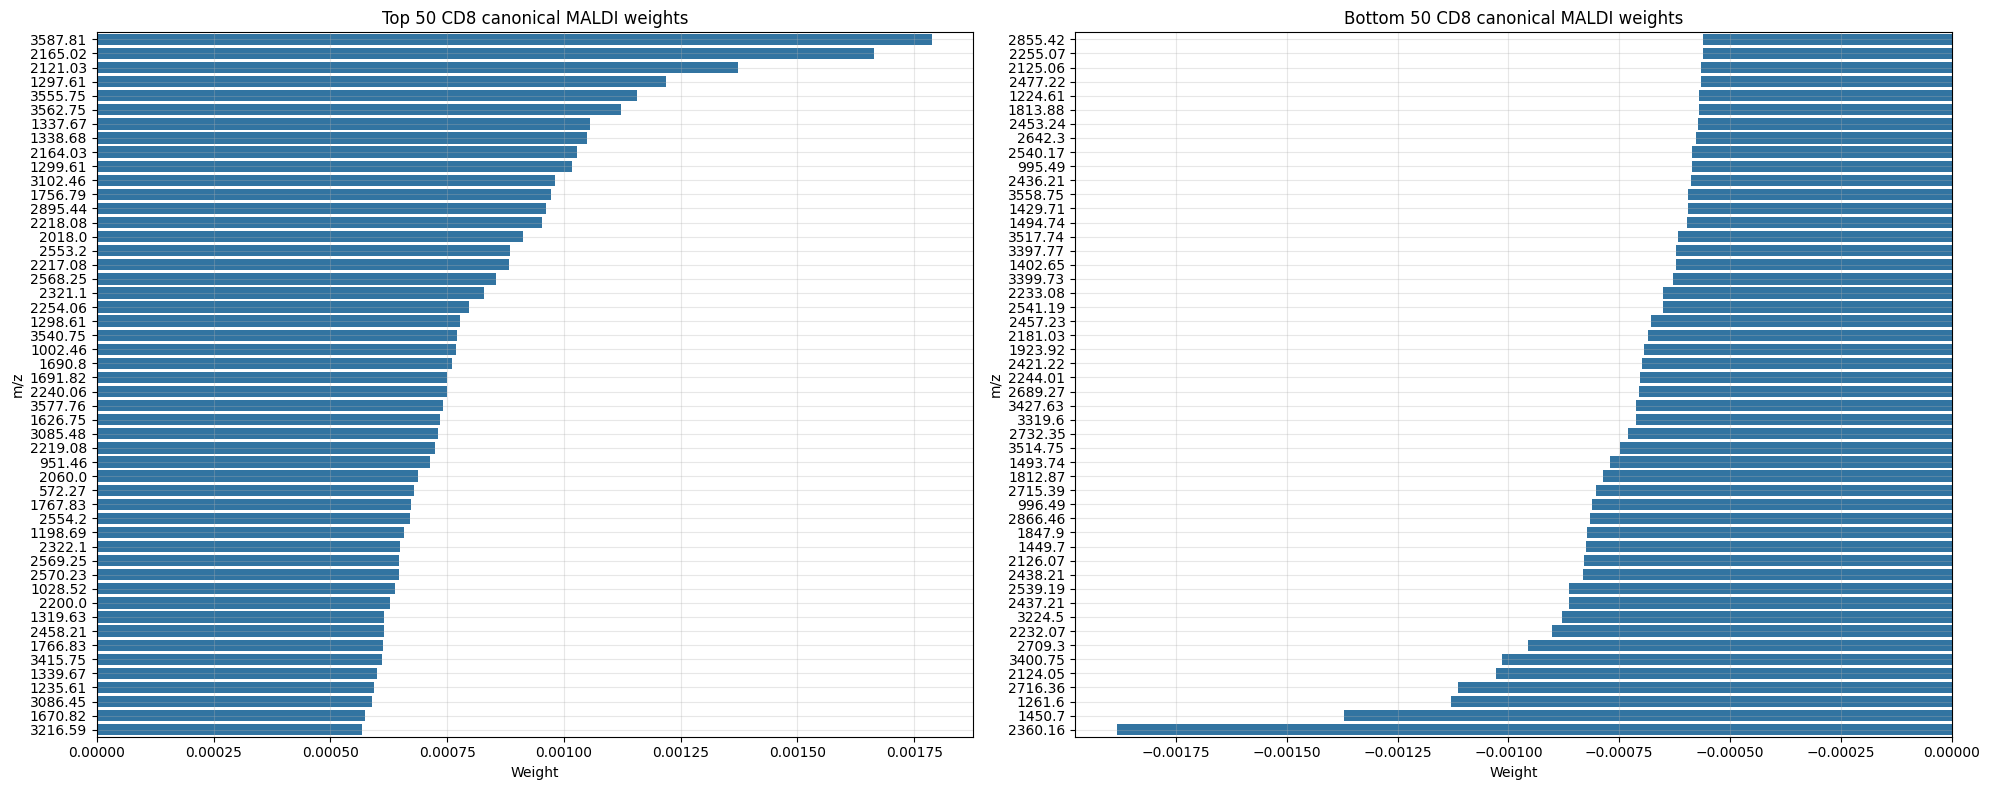

In [15]:
# Order the peaks by their weights
cd8_peaks_ordered = cd8_peaks.sort_values(by='weight', ascending=False)

# Transform the cd8_peaks datatypes
cd8_peaks_ordered['mz'] = cd8_peaks_ordered['mz'].round(2).astype(str)

# Plot the top 50 peaks
fig, ax = plt.subplots(1, 2, figsize=(20, 8), tight_layout=True)
sns.barplot(data=cd8_peaks_ordered.head(50), x='weight', y='mz', orient="h", ax=ax[0])
ax[0].set_title("Top 50 CD8 canonical MALDI weights")
ax[0].set_xlabel("Weight")
ax[0].set_ylabel("m/z")
ax[0].grid(alpha=0.3)

sns.barplot(data=cd8_peaks_ordered.tail(50), x='weight', y='mz', orient="h", ax=ax[1])
ax[1].set_title("Bottom 50 CD8 canonical MALDI weights")
ax[1].set_xlabel("Weight")
ax[1].set_ylabel("m/z")
ax[1].grid(alpha=0.3)

plt.show()

In [16]:
# Extract the peaks with a low correlations and high weights
non_cd8_signal = np.array([(np.abs(cd8_peaks['corr_pearson']) < 0.04) & (np.abs(cd8_peaks['weight']) > 0.001)])[0]

# Compute how many peaks are in the non_cd8_signal
print(f"Number of peaks with low correlations and high weights: {np.sum(non_cd8_signal)}")

cd8_peaks.loc[non_cd8_signal]

Number of peaks with low correlations and high weights: 9


,mz,weight,corr_pearson,corr_spearman,fold_change
332,1261.603409,-0.001129,-0.000459,0.037790,0.011022
388,1450.699754,-0.001372,0.030768,0.032519,0.533821
566,2124.053133,-0.001029,0.020383,0.039321,0.359099
620,2360.160375,-0.001884,0.027235,0.063311,0.495961
684,2716.360410,-0.001113,0.021351,0.001241,0.363206
773,3400.745804,-0.001015,0.008115,0.011193,0.205435
804,3555.754757,0.001157,0.016695,0.023032,0.472396
808,3562.746725,0.001123,0.016086,0.018786,0.456699
813,3587.811634,0.001787,0.017975,0.019101,0.447068


In [17]:
# Wright the mz of the peaks with low correlations and high weights in a file for mascot search
cd8_peaks.loc[non_cd8_signal, 'mz'].to_csv(f"{path}/results/non_cd8_signal.csv", index=False)

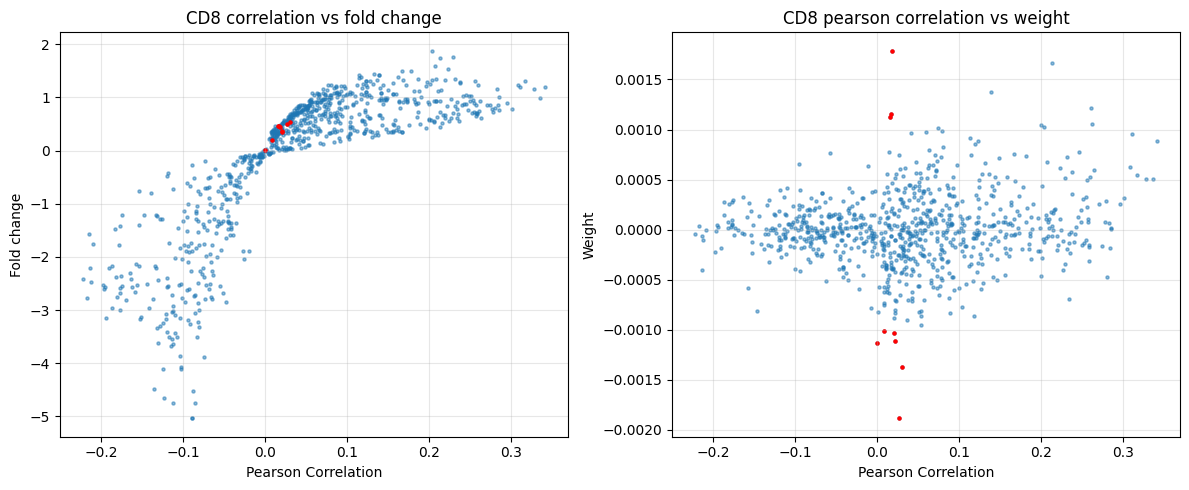

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
ax = ax.flatten()

ax[0].scatter(cd8_peaks['corr_pearson'], cd8_peaks['fold_change'], alpha=0.5, s=5)
ax[0].scatter(cd8_peaks['corr_pearson'][non_cd8_signal], cd8_peaks['fold_change'][non_cd8_signal], s=5, color='red')

ax[0].set_title("CD8 correlation vs fold change")
ax[0].set_xlabel("Pearson Correlation")
ax[0].set_ylabel("Fold change")
ax[0].grid(alpha=0.3)

ax[1].scatter(cd8_peaks['corr_pearson'], cd8_peaks['weight'], alpha=0.5, s=5)
ax[1].scatter(cd8_peaks['corr_pearson'][non_cd8_signal], cd8_peaks['weight'][non_cd8_signal], s=5, color='red')
ax[1].set_title("CD8 pearson correlation vs weight")
ax[1].set_xlabel("Pearson Correlation")
ax[1].set_ylabel("Weight")
ax[1].grid(alpha=0.3)

plt.show()

In [19]:
# Adjust the y values to be binary
y_train = y_train > threshold['Density_CD8']
y_test = y_test > threshold['Density_CD8']

# Create a logistic regression model
model_log = LogisticRegression(max_iter=10**6)

# Train the model
model_log.fit(X_train, y_train)

LogisticRegression(max_iter=1000000)

In [20]:
# Make predictions
y_pred = model_log.predict(X_test)

# Compute the accuracy using accuracy_score
accuracy_train = model_log.score(X_train, y_train)
accuracy_test = accuracy_score(y_test, y_pred)

print(f"Accuracy (train): {accuracy_train:.2f}")
print(f"Accuracy (test): {accuracy_test:.2f}")

Accuracy (train): 0.87
Accuracy (test): 0.86


# Sensitivity, specificity and ROC curve

ROC AUC: 0.85
Sensitivity: 0.33
Specificity: 0.96


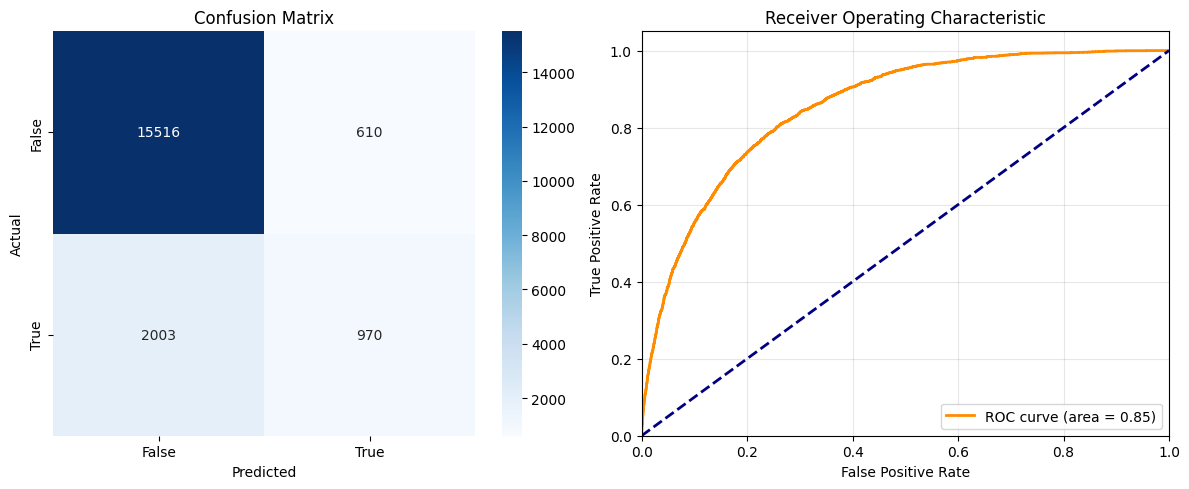

In [21]:
# Compute the True Positives, True Negatives, False Positives and False Negatives
true_positives = np.sum((y_test == 1) & (y_pred == 1))
true_negatives = np.sum((y_test == 0) & (y_pred == 0))
false_positives = np.sum((y_test == 0) & (y_pred == 1))
false_negatives = np.sum((y_test == 1) & (y_pred == 0))

# Compute the Sensitivity and Specificity
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Compute the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, model_log.predict_proba(X_test)[:, 1])

# Compute the ROC AUC
roc_auc = roc_auc_score(y_test, model_log.predict_proba(X_test)[:, 1])

print(f"ROC AUC: {roc_auc:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Plot the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")
ax[1].grid(alpha=0.3)

plt.show()

# Precision and Recall curve

AUC: 0.53
Intersection threshold: 0.34


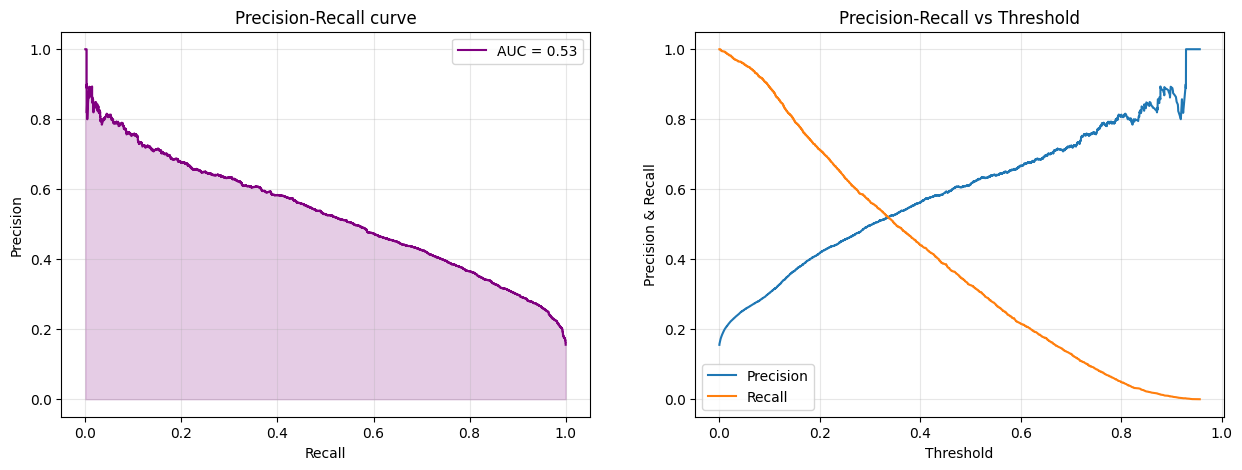

In [22]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, model_log.predict_proba(X_test)[:, 1])

# Compute the AUC
auc_score = auc(recall, precision)

# Calculate the intersection threshold
intersection_threshold = thresholds[np.argmin(np.abs(recall - precision))]

print(f"AUC: {auc_score:.2f}")
print(f"Intersection threshold: {intersection_threshold:.2f}")

# Plot the precision-recall curve
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(recall, precision, color="purple", label=f"AUC = {auc_score:.2f}")
ax[0].fill_between(recall, precision, alpha=0.2, color="purple")
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].set_title(f"Precision-Recall curve")
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(thresholds, precision[:-1], label="Precision")
ax[1].plot(thresholds, recall[:-1], label="Recall")
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Precision & Recall")
ax[1].set_title(f"Precision-Recall vs Threshold")
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.show()

Accuracy: 0.85
True Positives: 1546
True Negatives: 14700
False Positives: 1426
False Negatives: 1427
Sensitivity: 0.52
Specificity: 0.91


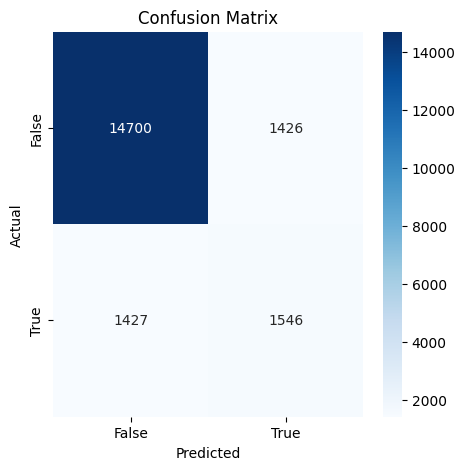

In [23]:
# Predict the CD8 density using the logistic regression model with the intersection threshold
y_pred = model_log.predict_proba(X_test)[:, 1] > intersection_threshold

# Compute the accuracy using accuracy_score
accuracy = accuracy_score(y_test, y_pred)

# Compute the True Positives, True Negatives, False Positives and False Negatives
true_positives = np.sum((y_test == 1) & y_pred)
true_negatives = np.sum((y_test == 0) & ~y_pred)
false_positives = np.sum((y_test == 0) & y_pred)
false_negatives = np.sum((y_test == 1) & ~y_pred)

# Compute the Sensitivity and Specificity
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Compute the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f"Accuracy: {accuracy:.2f}")
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Lasso regularization (L1)

In [24]:
# Create a logistic regression model with Lasso regularization (L1)
model_log_l1 = LogisticRegression(max_iter=10**6, penalty='l1', solver='liblinear')

# Train the model
model_log_l1.fit(X_train, y_train)

LogisticRegression(max_iter=1000000, penalty='l1', solver='liblinear')

In [25]:
# Make predictions
y_pred = model_log_l1.predict(X_test)

# Compute the accuracy using accuracy_score
accuracy_train = model_log_l1.score(X_train, y_train)
accuracy_test = accuracy_score(y_test, y_pred)

print(f"Accuracy (train): {accuracy_train:.2f}")
print(f"Accuracy (test): {accuracy_test:.2f}")

Accuracy (train): 0.87
Accuracy (test): 0.86


True Positives: 972
True Negatives: 15519
False Positives: 607
False Negatives: 2001
Sensitivity: 0.33
Specificity: 0.96
ROC AUC: 0.85


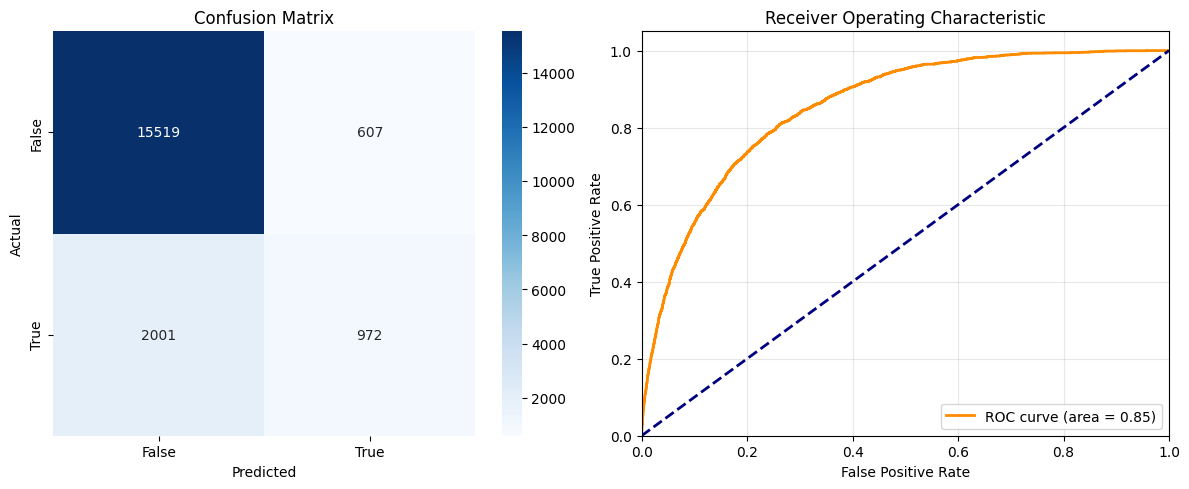

In [26]:
# Compute the True Positives, True Negatives, False Positives and False Negatives
true_positives = np.sum((y_test == 1) & y_pred)
true_negatives = np.sum((y_test == 0) & ~y_pred)
false_positives = np.sum((y_test == 0) & y_pred)
false_negatives = np.sum((y_test == 1) & ~y_pred)

# Compute the Sensitivity and Specificity
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Compute the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, model_log_l1.predict_proba(X_test)[:, 1])

# Compute the ROC AUC
roc_auc = roc_auc_score(y_test, model_log_l1.predict_proba(X_test)[:, 1])

print(f"ROC AUC: {roc_auc:.2f}")

# Plot the confusion matrix and the ROC curve
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic')
ax[1].legend(loc="lower right")
ax[1].grid(alpha=0.3)

plt.show()

AUC: 0.53
Intersection threshold: 0.34


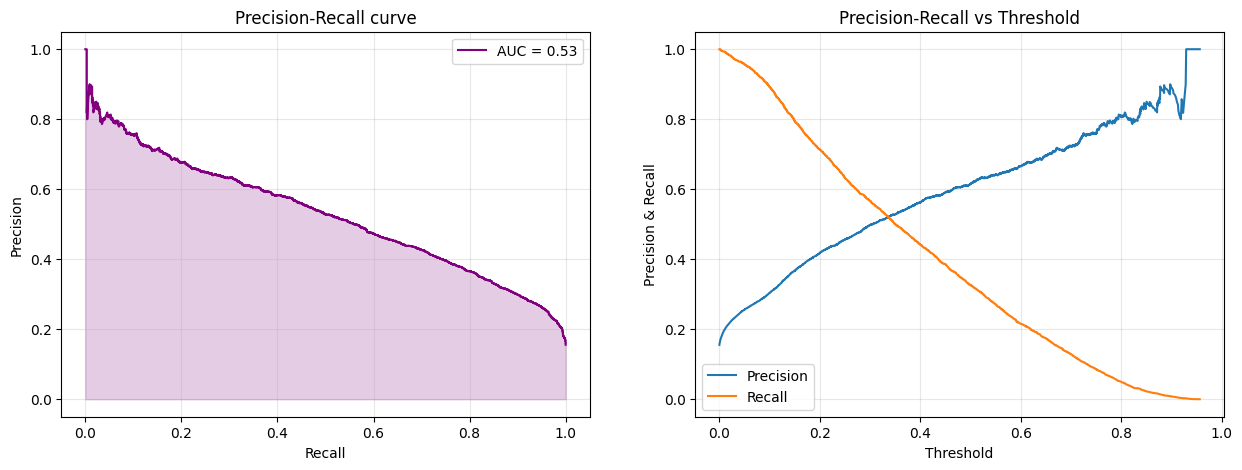

In [27]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, model_log_l1.predict_proba(X_test)[:, 1])

# Compute the AUC
auc_score = auc(recall, precision)

# Calculate the intersection threshold
intersection_threshold = thresholds[np.argmin(np.abs(recall - precision))]

print(f"AUC: {auc_score:.2f}")
print(f"Intersection threshold: {intersection_threshold:.2f}")

# Plot the precision-recall curve
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(recall, precision, color="purple", label=f"AUC = {auc_score:.2f}")
ax[0].fill_between(recall, precision, alpha=0.2, color="purple")
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].set_title(f"Precision-Recall curve")
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(thresholds, precision[:-1], label="Precision")
ax[1].plot(thresholds, recall[:-1], label="Recall")
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Precision & Recall")
ax[1].set_title(f"Precision-Recall vs Threshold")
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.show()